# Lesson 27: Hacker statistics

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l27_hackerstats.ipynb).*

In [1]:
import numpy as np

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

When the field of statistics was in its early days, the practitioners did not have computers. They were therefore left to use pen and paper to compute things like confidence intervals. With just a little bit of programming experience, you can perform lots of the statistical analyses that may seem baffling when done with pencil and paper.

At the heart of this "hacker statistics" is the ability to draw random numbers. We will focus on **bootstrap** methods in particular.

To motivate this study, we will work with data measured by Peter and Rosemary Grant on the island of Daphne Major on the Galápagos. They have been going to the island every year for over forty years and have been taking a careful inventory of the finches there. We will look at the finch *Geospiza scandens*. The Grants measured the depths of the beaks (defined as the top-to-bottom thickness of the beak) of all of the finches of this species on the island. We will consider their measurements from 1975 and from 2012. We will investigate if the beaks got deeper over time.

The data are from the book Grants' book *40 years of evolution: Darwin's finches on Daphne Major Island*](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.

Ok, let's start by loading in the data. The beak depths are stored in the files `~/git/data/beak_depth_scandens_1975.csv` and `~/git/data/beak_depth_scandens_2012.csv`.

In [24]:
bd_1975 = np.loadtxt('data/beak_depth_scandens_1975.csv')
bd_2012 = np.loadtxt('data/beak_depth_scandens_2012.csv')

We'll use the `ecdf()` function you wrote yesterday to generate the ECDFs so we can plot them. I'll define it here so we have it going forward.

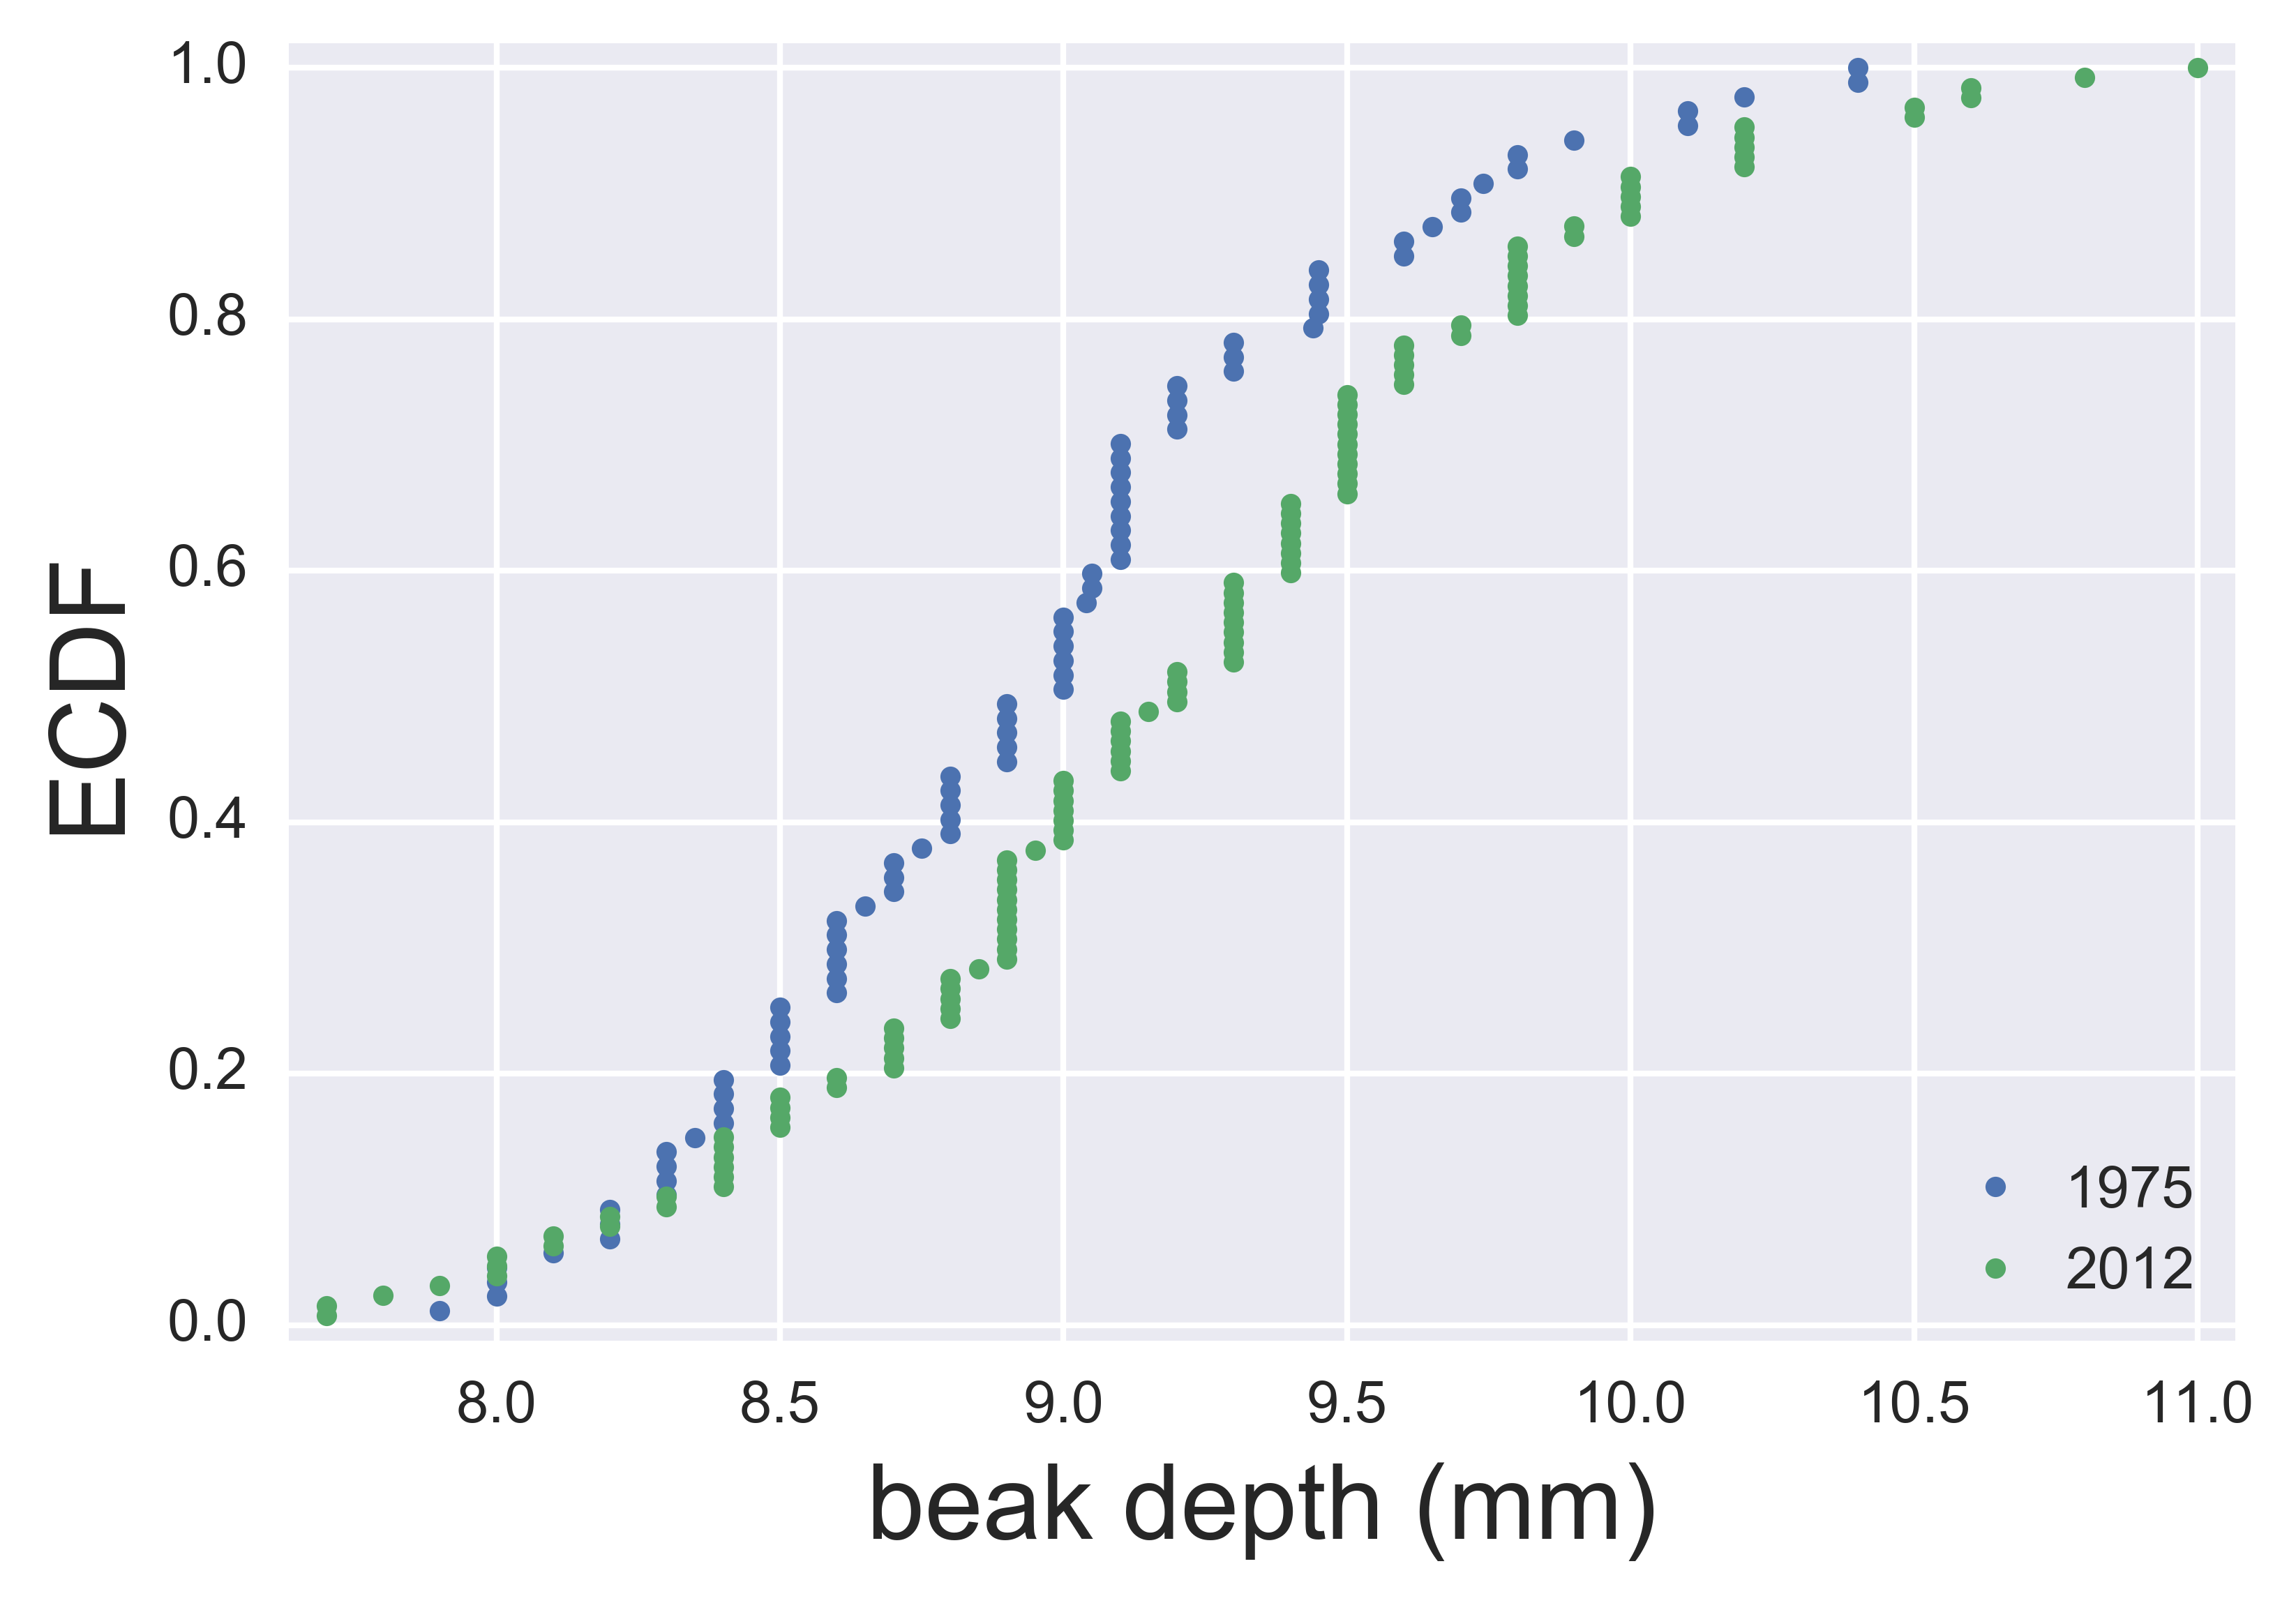

In [26]:
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Compute ECDFs for 1975 and 2012
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
plt.plot(x_1975, y_1975, marker='.', linestyle='none')
plt.plot(x_2012, y_2012, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right')

Judging from the ECDFs, it seems as though beaks have gotten deeper over time. But now, we would like a *statistic* to compare. One statistic that comes to mind it the mean. So, let's compare those.

In [27]:
np.mean(bd_1975), np.mean(bd_2012)

(8.9599999999999991, 9.1862204724409455)

So, indeed, the mean beak depth is bigger in 2012 than in 1975. There is clearly some variability in beak depth among the birds measured each year, so it is possible that this observation is just due to random chance and the mean beak depth is really not that big. So, we would like to compute a *confidence interval* on the mean. We will compute the 95% confidence interval.

What is a 95% confidence interval? It can be thought of as follows. If we were to repeat the experiment over and over and over again, 95% of the time, the observed mean would lie in the 95% confidence interval. So, if the confidence intervals of the means of measurements from 1975 and from 2012 overlapped, we might not be so sure that the beaks got deeper due to some underlying selective pressure, but that we just *observed* deeper beaks as a result of natural variability.

So, how do we compute a confidence interval? We use our computer!

## Bootstrap confidence intervals

The notion of the bootstrap was first published by Brad Efron in 1979. The idea is simple, and we will take the fact that it works as given; Efron proved it for us. 

Here's the idea: If we could repeat the measurements of the beak depths on Daphne Major, we could do it many many times, and we could then just compute the 2.5th and 97.5th percentiles to get a 95% confidence interval. The problem is, we can't repeat the experiments over and over again. Instead, we will have our computer *simulate* doing the experiment over and over again. Hacker statistics! We have a set of measurements; we just use them over and over again. Here's what we do to compute a bootstrap estimate of the mean of a set of $n$ data points.
>1. Draw $n$ data points out of the original data set *with replacement*. This set of data points is called a **bootstrap sample**.
2. Compute the mean of the bootstrap sample. This is called a **bootstrap replicate** of the mean.
3. Do this over and over again, storing the results.

So, it is as if we did the experiment over and over again, obtaining a mean each time. Remember, our bootstrap sample has exactly the same number of "measurements" as the original data set. Let's try it with the `bd_1975` data (remember the mean beak depth was 8.96 mm). First we'll generate a bootstrap sample. Remember, the function `np.random.choice()` allows us to sample out of an array with replacement, if we like.

In [30]:
bs_sample = np.random.choice(bd_1975, replace=True, size=len(bd_1975))

Let's take a quick look at this bootstrap sample by plotting its ECDF right next to that of the original data set.

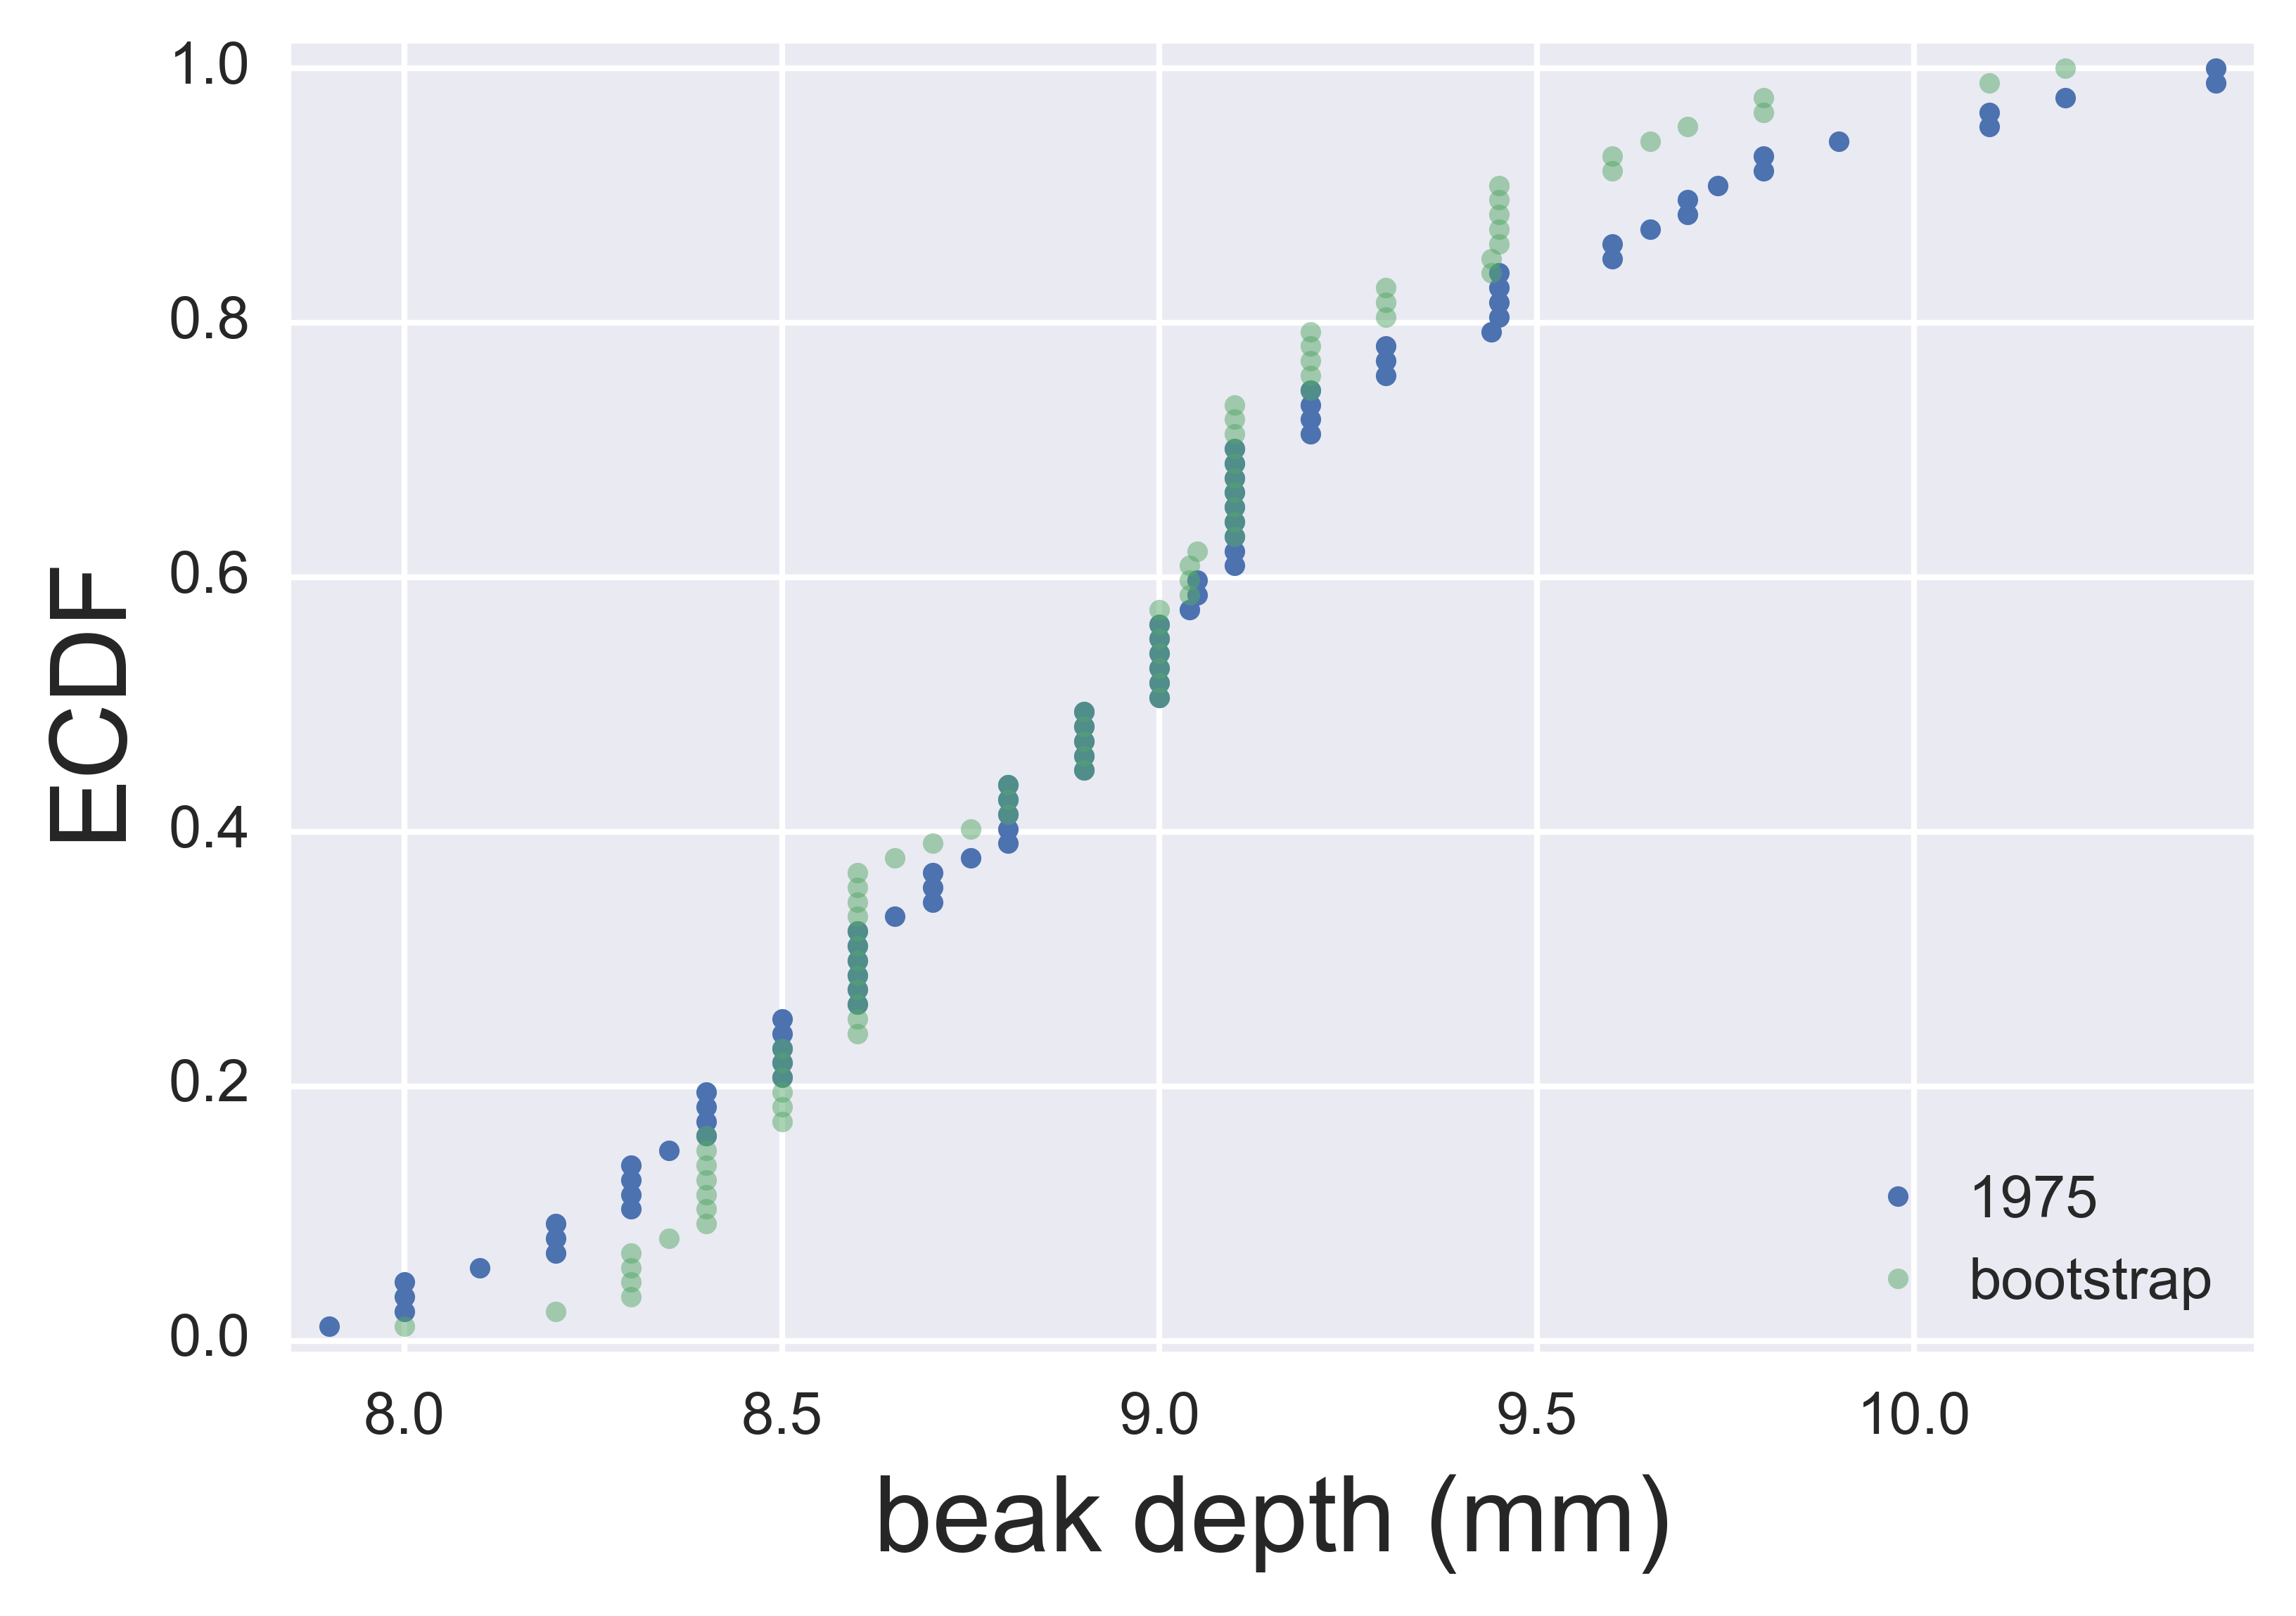

In [33]:
# Compute ECDF of bootstrap sample
x_bs, y_bs = ecdf(bs_sample)

# Plot the ECDFs
plt.plot(x_1975, y_1975, marker='.', linestyle='none')
plt.plot(x_bs, y_bs, marker='.', linestyle='none', alpha=0.5)
plt.margins(0.02)
plt.xlabel('beak depth (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', 'bootstrap'), loc='lower right')

It is qualitatively similar, but obviously not exactly the same data set.

Now, let's compute our bootstrap replicated. It's as simple as computing the mean of the bootstrap sample.

In [35]:
bs_replicate = np.mean(bs_sample)
bs_replicate

8.9241379310344833

So, the mean of the bootstrap replicate is 8.92 mm, which is less than the mean of 8.96 from the original data set.

Now, we can write a **`for`** loop to get lots and lots of bootstrap replicas.

In [44]:
# Number of replicas
n_reps = 100000

# Initialize bootstrap replicas array
bs_replicates_1975 = np.empty(n_reps)

# Compute replicates
for i in range(n_reps):
    bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
    bs_replicates_1975[i] = np.mean(bs_sample)

Now that we have our replicas, 100,000 of them, we can plot a histogram to see what we might expect of the mean if we were to do the experiment again. We use the `normed=True` kwarg do that the histogram approximates a probability distribution function.

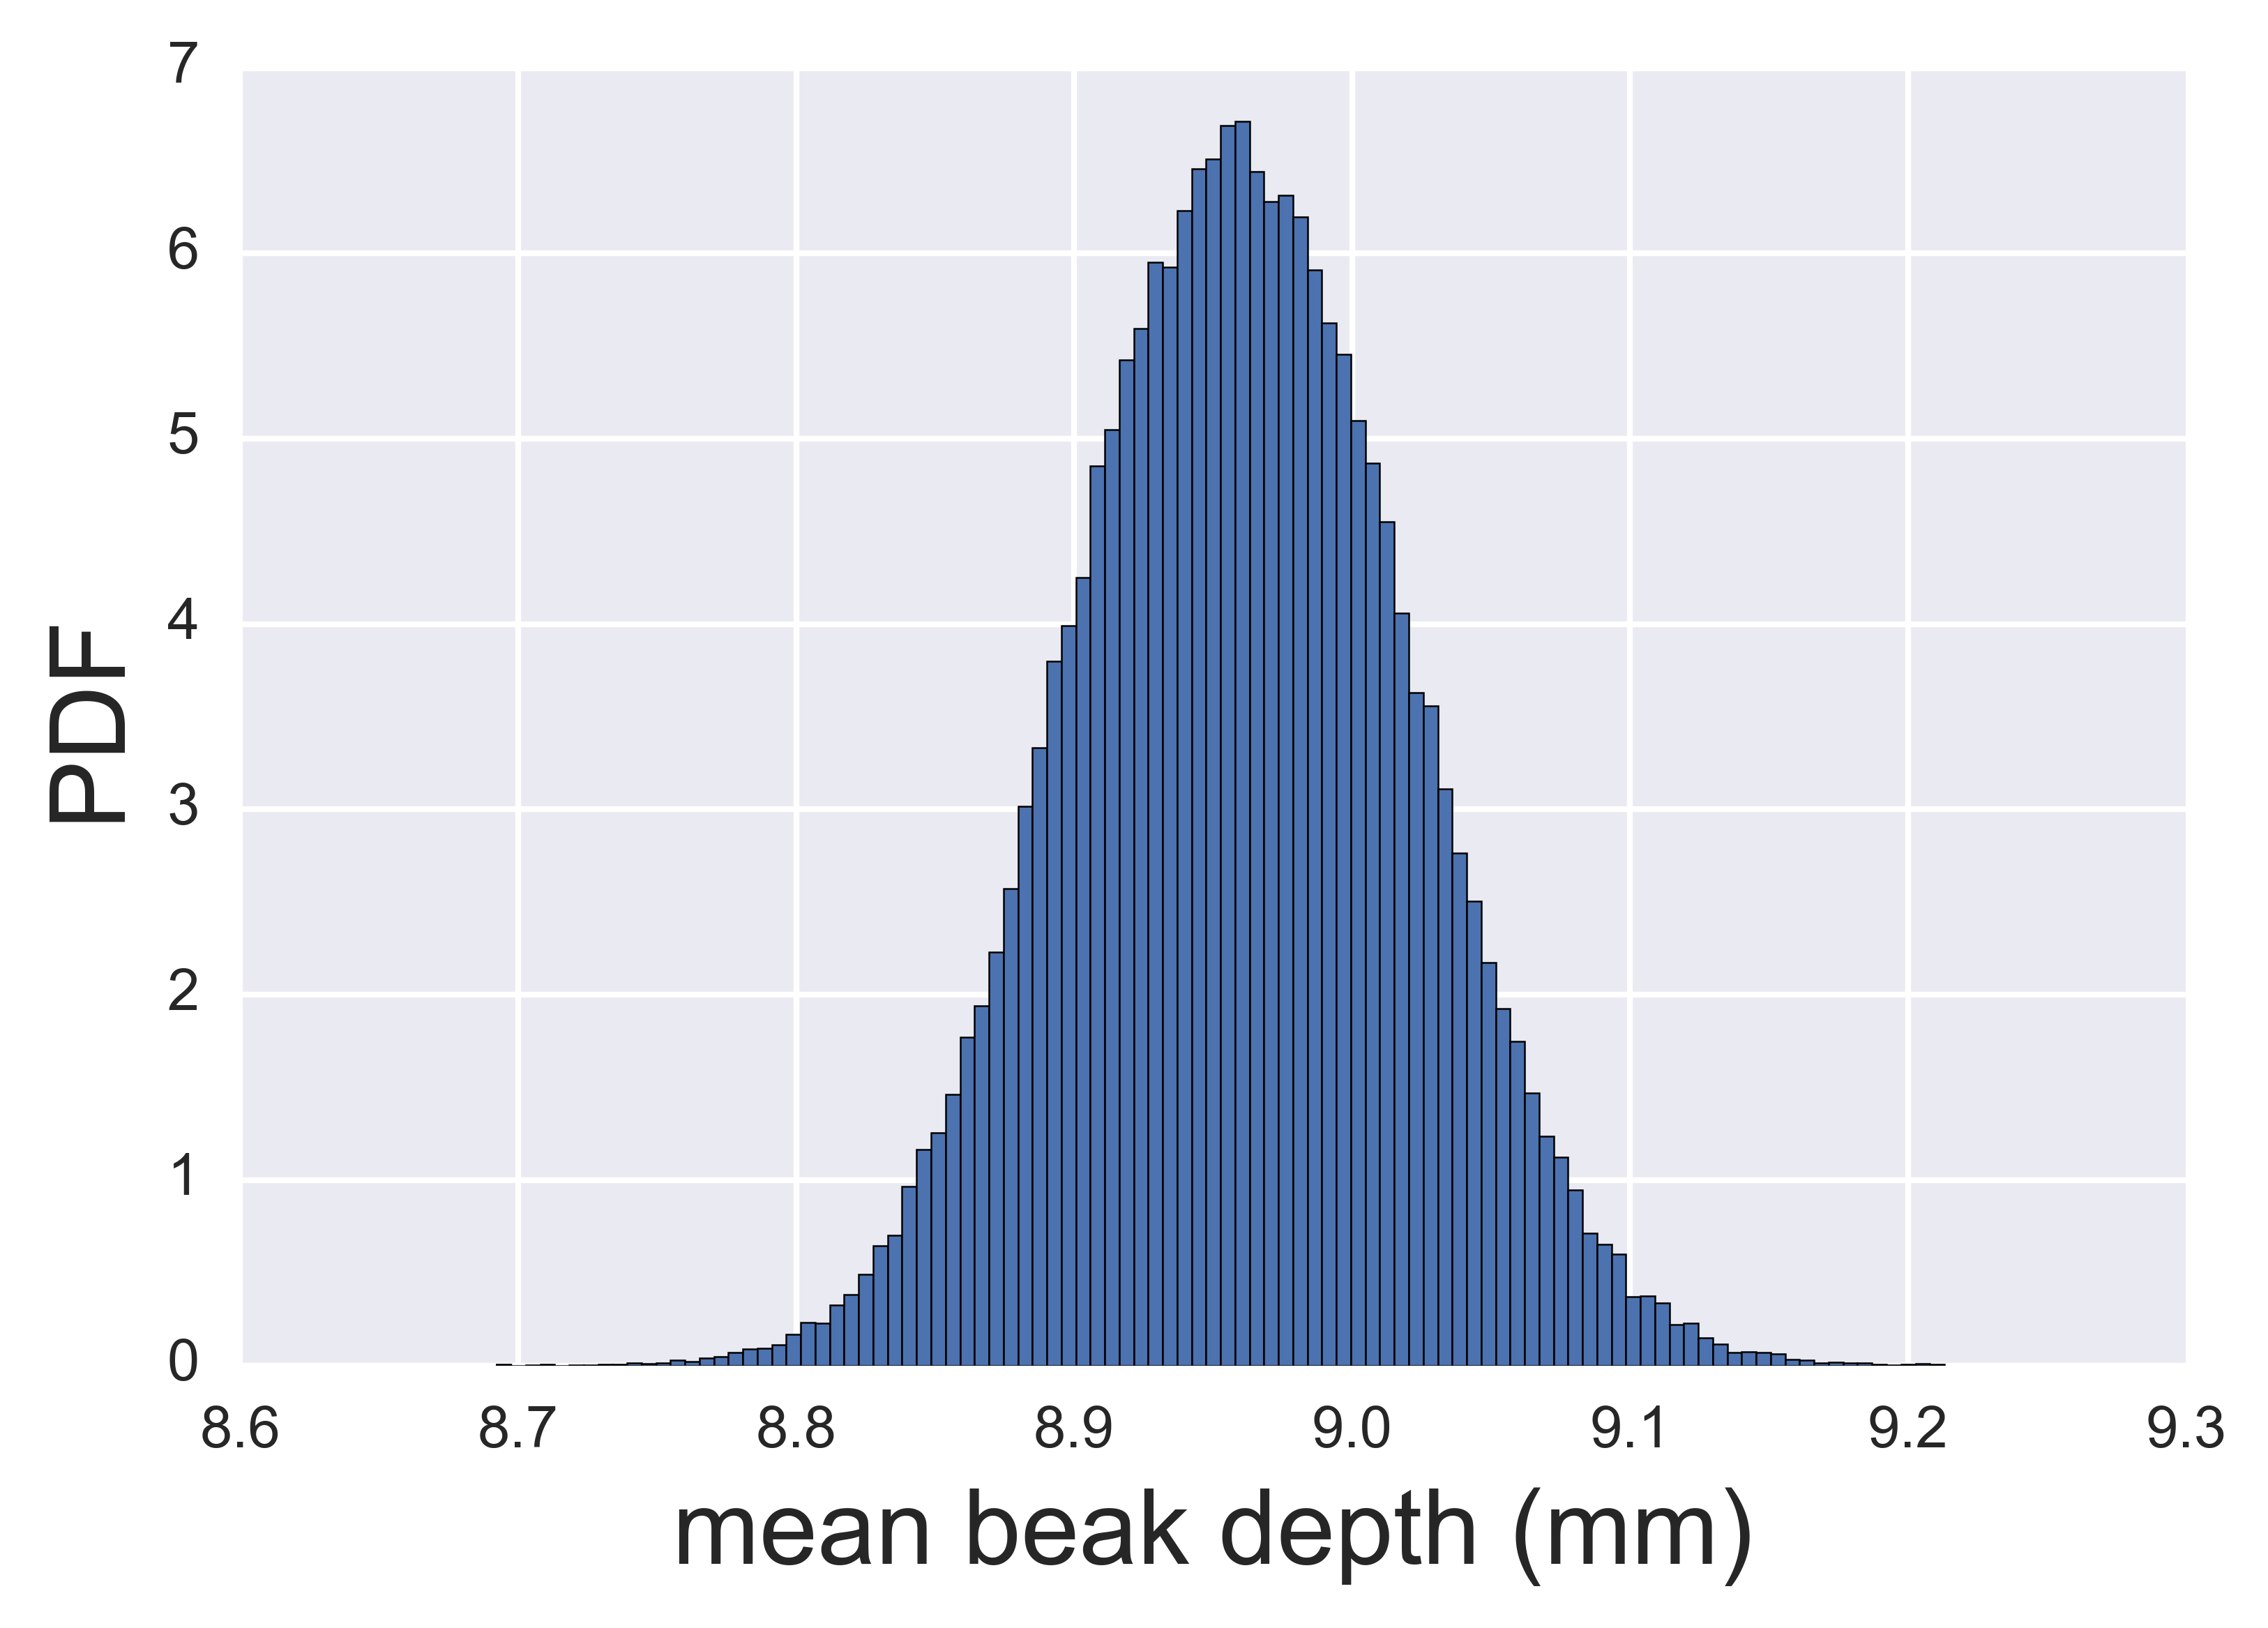

In [45]:
_ = plt.hist(bs_replicates_1975, bins=100, normed=True)
plt.xlabel('mean beak depth (mm)')
plt.ylabel('PDF')

It looks Normally distributed, and in fact it must be by the Central Limit Theorem (which we will not discuss here, but we didn't really need to derive; hacker statistics brought us here!). The most probable mean we would get is 8.96 mm, which was what was measured, but upon repeating the experiment, we could get a mean as low as about 8.7 mm or as high as about 9.2 mm.

Let's compute the 95% confidence interval.

In [48]:
conf_int_1975 = np.percentile(bs_replicates_1975, [2.5, 97.5])
conf_int_1975

array([ 8.84367816,  9.07908046])

Great! Now let's do the same thing for the 2012 samples.

In [49]:
# Number of replicas
n_reps = 100000

# Initialize bootstrap replicas array
bs_replicates_2012 = np.empty(n_reps)

# Compute replicates
for i in range(n_reps):
    bs_sample = np.random.choice(bd_2012, size=len(bd_2012))
    bs_replicates_2012[i] = np.mean(bs_sample)
    
# Compute the confidence interval
conf_int_2012 = np.percentile(bs_replicates_2012, [2.5, 97.5])

Now, let's print the two confidence intervals next to each other for comparison.

In [50]:
print(conf_int_1975)
print(conf_int_2012)

[ 8.84367816  9.07908046]
[ 9.07047244  9.3019685 ]


So, the 95% confidence intervals for the 2012 and 1975 juuust miss each other. This implies that the inherent variation in beak depths is likely not responsible for the observed difference. There was likely some selective pressure toward deeper beaks.

## Bootstrap confidence interval of the standard deviation

We are not limited to computing bootstrap confidence intervals of the mean. We could compute bootstrap confidence intervals of any statistic, like the median, standard deviation, the mean divided by the standard deviation, whatever we like. Computing the confidence interval for the standard deviation is the same procedure as we have done; we just put `np.std` in for `np.mean`.

[ 0.47754331  0.63875042]


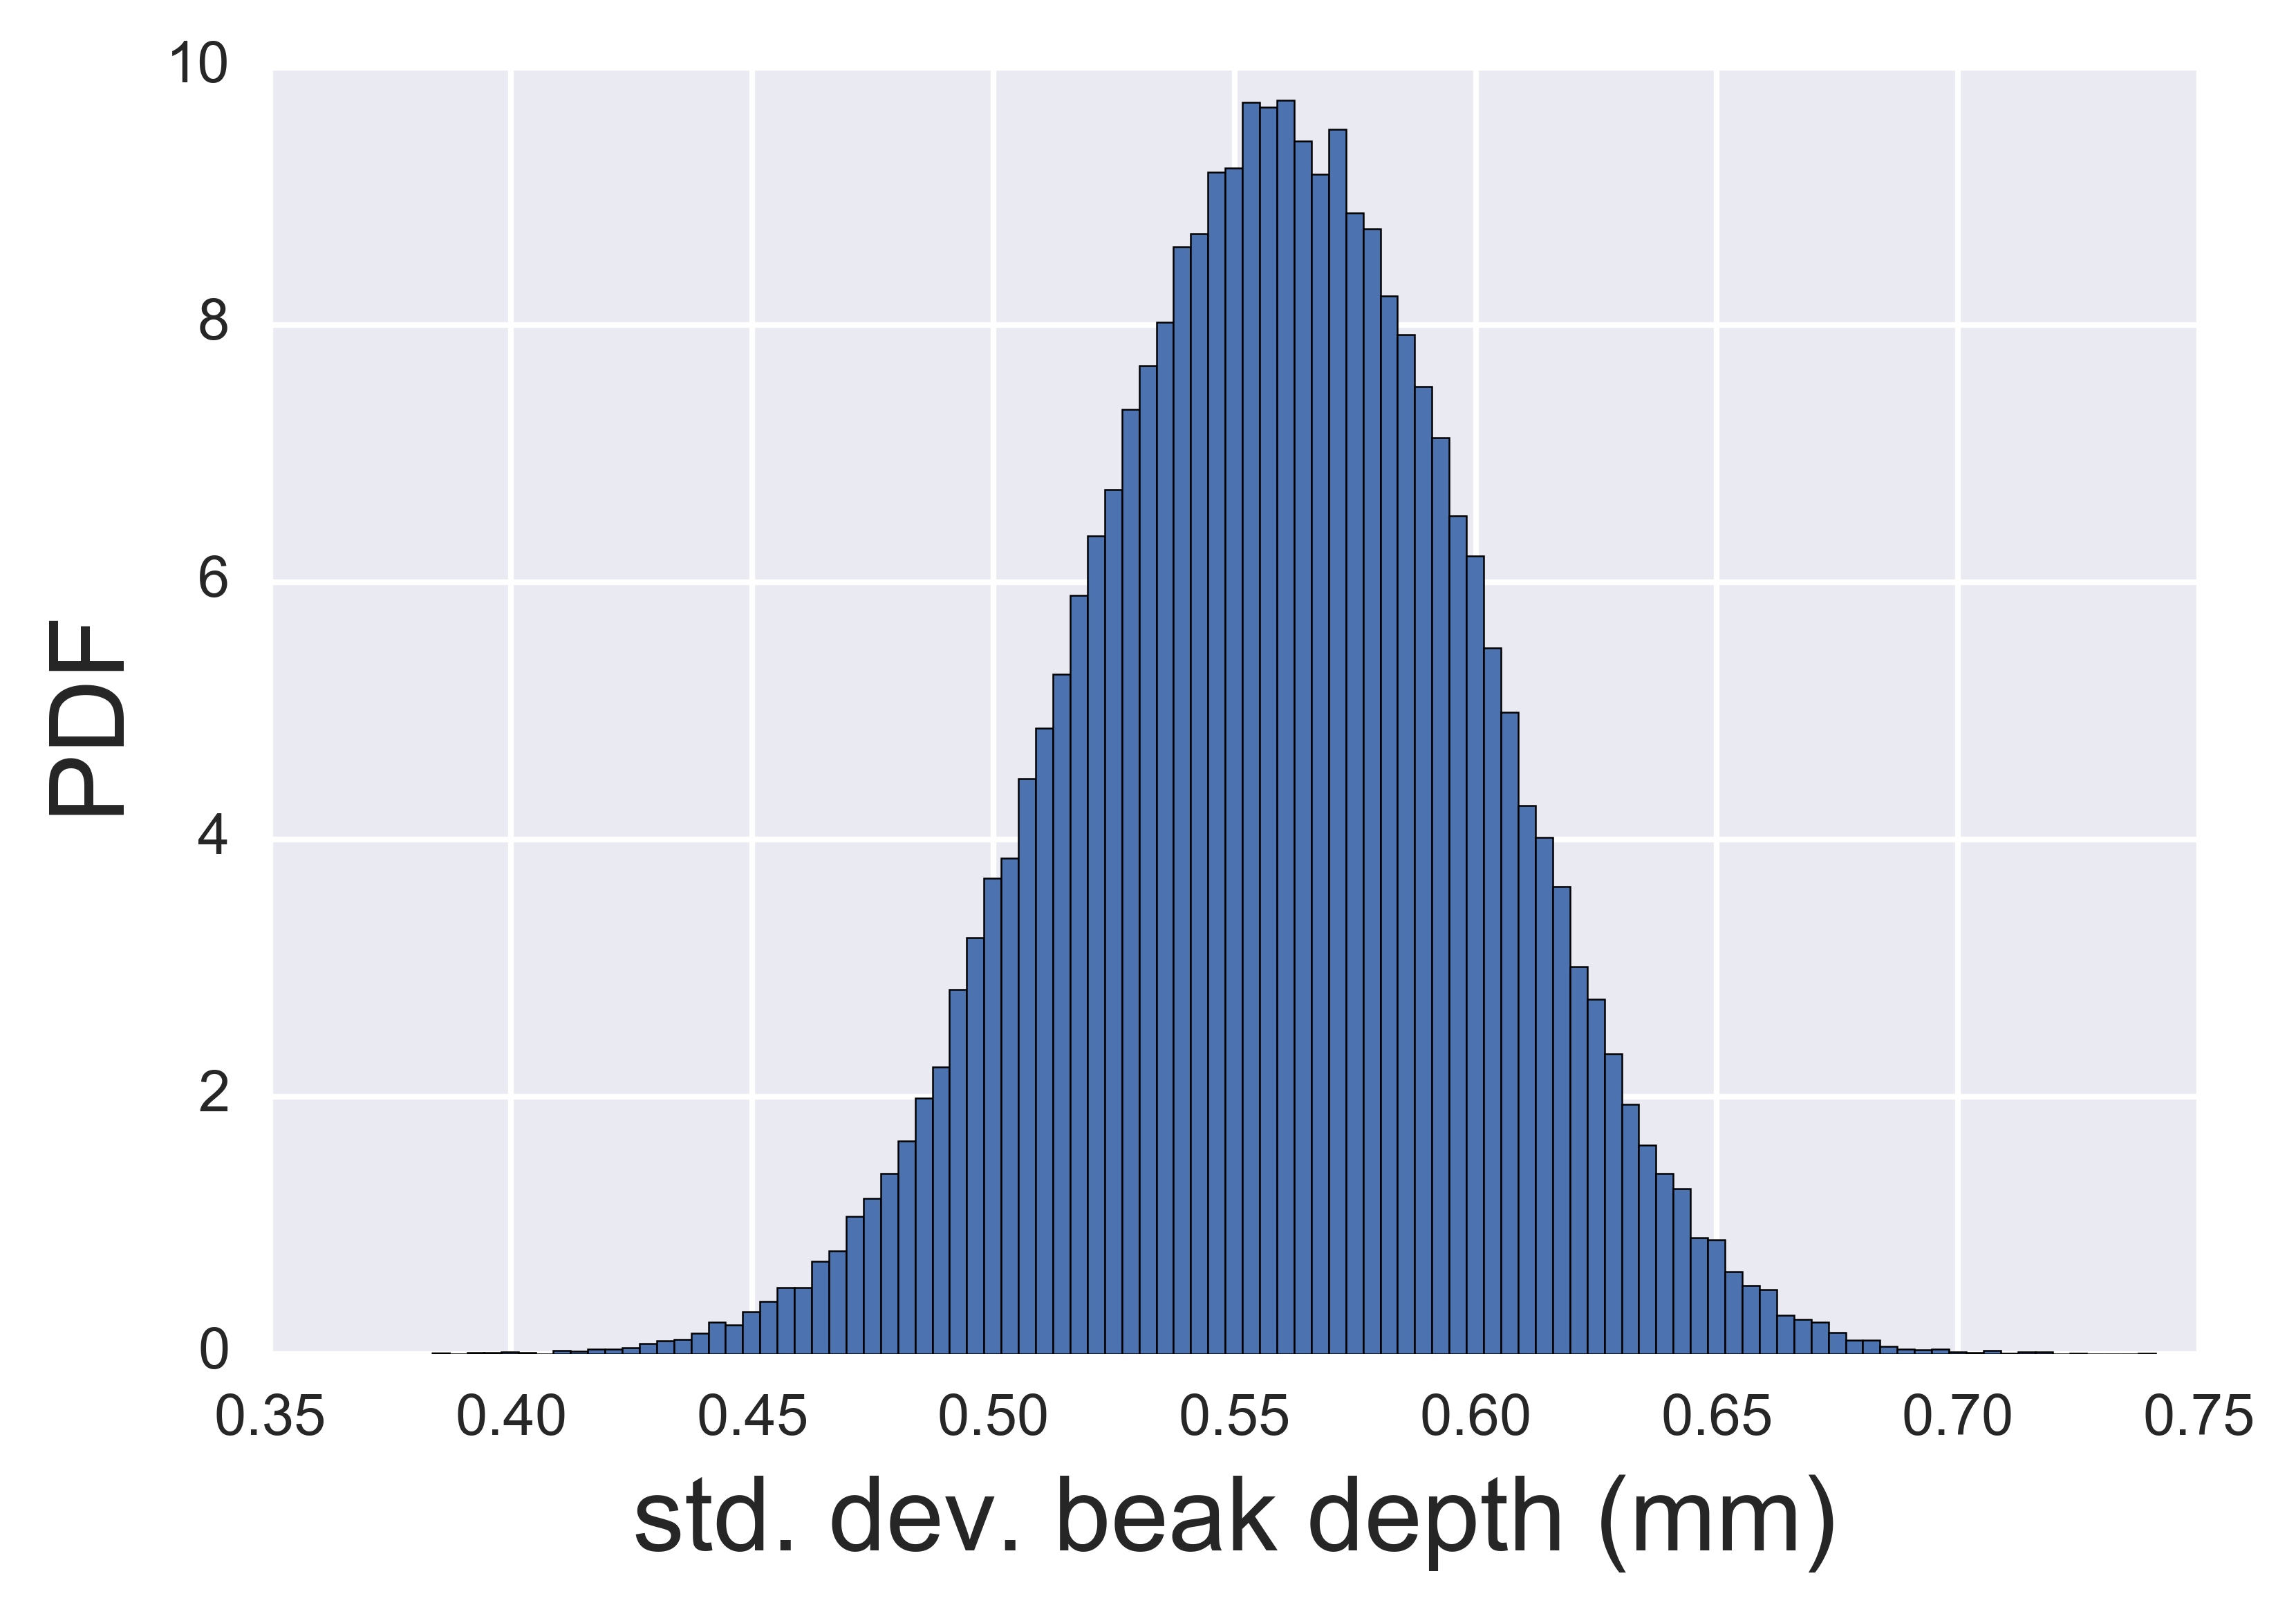

In [55]:
# Number of replicas
n_reps = 100000

# Initialize bootstrap replicas array
bs_replicates_1975 = np.empty(n_reps)

# Compute replicates
for i in range(n_reps):
    bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
    bs_replicates_1975[i] = np.std(bs_sample)
    
# Compute confidence interval
conf_int_1975 = np.percentile(bs_replicates_1975, [2.5, 97.5])
print(conf_int_1975)

# Plot histogram
_ = plt.hist(bs_replicates_1975, bins=100, normed=True)
plt.xlabel('std. dev. beak depth (mm)')
plt.ylabel('PDF')

So, we now also have an estimate for the variability in beak depth. It could range from about 0.48 to 0.64 mm.